# Predict Biological Response

Данные представлены в формате CSV.  Каждая строка представляет молекулу. 

Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1];    
Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать F1-score.

Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

%matplotlib inline
plt.style.use('seaborn')

In [3]:
data = pd.read_csv('./drive/MyDrive/DT_courser/7_Model hyperparameter optimization/data/biological.csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [4]:
data.shape

(3751, 1777)

#### Проверяем наличие пропусков

In [5]:
cols_null = data.isnull().sum()
cols_null[cols_null>0]

Series([], dtype: int64)

In [6]:
data.describe()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
count,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,...,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000
mean,0.542255,0.076948,0.592436,0.068142,0.038990,0.212112,0.686653,0.274713,0.455133,0.749517,...,0.026926,0.014663,0.013863,0.021861,0.015196,0.016796,0.012263,0.011730,0.020261,0.011197
std,0.498278,0.079989,0.105860,0.078414,0.115885,0.102592,0.078702,0.090017,0.162731,0.071702,...,0.161889,0.120215,0.116938,0.146249,0.122348,0.128522,0.110074,0.107683,0.140911,0.105236
min,0.000000,0.000000,0.282128,0.000000,0.000000,0.002630,0.137873,0.006130,0.000000,0.275590,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.033300,0.517811,0.000000,0.000000,0.138118,0.625627,0.207374,0.378062,0.707339,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.066700,0.585989,0.050000,0.000000,0.190926,0.674037,0.277845,0.499942,0.738961,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.100000,0.668395,0.100000,0.000000,0.261726,0.740663,0.335816,0.569962,0.788177,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,0.964381,0.950000,1.000000,1.000000,0.994735,0.790831,0.989870,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Смотрим на сбалансированность классов:

1    0.542255
0    0.457745
Name: Activity, dtype: float64

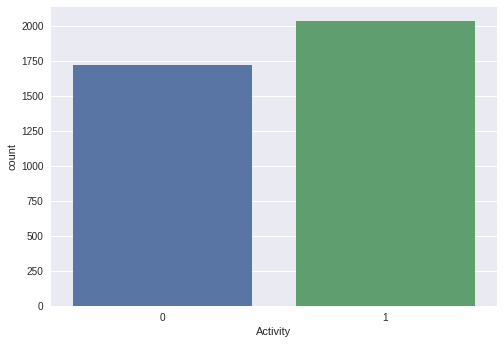

In [7]:
display(data['Activity'].value_counts(normalize=True))
sns.countplot(data=data, x='Activity')

### Подготовка данных

In [8]:
X = data.drop('Activity', axis=1)
y = data['Activity']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

In [10]:
display(y_train.value_counts(normalize=True))
display(y_test.value_counts(normalize=True))

1    0.542333
0    0.457667
Name: Activity, dtype: float64

1    0.541944
0    0.458056
Name: Activity, dtype: float64

### <center> **Логистическая регрессия**

In [11]:
log_reg = linear_model.LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_test_pred = log_reg.predict(X_test)
print('F1_score on the test set: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

F1_score on the test set: 0.78


#### Method GridSeachCV

In [12]:
from sklearn.model_selection import GridSearchCV

In [13]:
param_grid = {'solver': ['lbfgs', 'saga'], 
               'penalty': ['l2', 'none'],
              'C': [0.01, 0.1, 0.5, 0.7, 1]}

In [14]:
grid_search = GridSearchCV(
  estimator=linear_model.LogisticRegression(
      random_state=42, 
      max_iter=1000
      ),
  param_grid=param_grid,
  cv=5,
  n_jobs=-1
)

In [15]:
%time
grid_search.fit(X_train, y_train)
y_test_pred = grid_search.predict(X_test)
print('F1_score on the test set: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Best hyperparameter values: {}'.format(grid_search.best_params_))

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs
F1_score on the test set: 0.79
Best hyperparameter values: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}


#### Method RandomizedSearchCV

In [16]:
from sklearn.model_selection import RandomizedSearchCV

In [17]:
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_grid, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
) 

In [18]:
%time 
random_search.fit(X_train, y_train) 
y_test_pred = random_search.predict(X_test)
print('F1_score on the test set: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Best hyperparameter values: {}'.format(random_search.best_params_))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
F1_score on the test set: 0.79
Best hyperparameter values: {'solver': 'saga', 'penalty': 'l2', 'C': 0.1}


#### Optuna

In [20]:
#!pip install optuna

In [21]:
import optuna

In [23]:
def optuna_lr(trial):
  # задаем пространства поиска гиперпараметров
  solver = trial.suggest_categorical('solver', ['lbfgs', 'saga'])
  penalty = trial.suggest_categorical('penalty', ['l2', 'none'])
  C = trial.suggest_float('C', 0.1, 1, step=0.1)

  # создаем модель
  model = linear_model.LogisticRegression(
      penalty=penalty,
      solver=solver,
      C=C,
      random_state=42, 
      max_iter=1000,
      n_jobs=-1
      )
  
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [24]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_lr, n_trials=5)

[I 2022-05-25 08:50:26,138] A new study created in memory with name: LogisticRegression
[I 2022-05-25 08:51:15,183] Trial 0 finished with value: 0.8807339449541284 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.8}. Best is trial 0 with value: 0.8807339449541284.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
[I 2022-05-25 08:52:24,635] Trial 1 finished with value: 0.9172519083969467 and parameters: {'solver': 'saga', 'penalty': 'none', 'C': 0.2}. Best is trial 1 with value: 0.9172519083969467.
[I 2022-05-25 08:52:54,199] Trial 2 finished with value: 0.8731617647058824 and parameters: {'solver': 'saga', 'penalty': 'l2', 'C

CPU times: user 2min 28s, sys: 624 ms, total: 2min 28s
Wall time: 4min 2s


In [25]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'solver': 'saga', 'penalty': 'none', 'C': 0.2}
f1_score на обучающем наборе: 0.92


In [27]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
      **study.best_params,
      random_state=42, 
      max_iter=1000,
      n_jobs=-1
      )

model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [28]:
print('F1_score on the test set: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

F1_score on the test set: 0.76


In [29]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

### <center> **Случайный лес**

In [30]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('F1_score on the train set: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('F1_score on the test set: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

F1_score on the train set: 1.00
F1_score on the test set: 0.81


#### Method GridSeachCV

In [31]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }

In [34]:
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
    )

In [35]:
%time
grid_search_forest.fit(X_train, y_train) 
y_test_pred = grid_search_forest.predict(X_test)
print('F1_score on the test set: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Best hyperparameter values: {}'.format(grid_search_forest.best_params_))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs
F1_score on the test set: 0.82
Best hyperparameter values: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 140}


#### Method RandomizedSearchCV

In [37]:
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_grid, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  

In [38]:
%time
random_search_forest.fit(X_train, y_train)
y_test_pred = random_search_forest.predict(X_test)
print('F1_score on the test set: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Best hyperparameter values: {}'.format(random_search_forest.best_params_))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
F1_score on the test set: 0.82
Best hyperparameter values: {'n_estimators': 80, 'min_samples_leaf': 5, 'max_depth': 40}


#### Optuna

In [39]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 300, 10)
  max_depth = trial.suggest_int('max_depth', 15, 40, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 7, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [40]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2022-05-25 09:08:15,585] A new study created in memory with name: RandomForestClassifier
[I 2022-05-25 09:08:19,533] Trial 0 finished with value: 0.9463414634146341 and parameters: {'n_estimators': 250, 'max_depth': 33, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9463414634146341.
[I 2022-05-25 09:08:23,695] Trial 1 finished with value: 0.9463414634146341 and parameters: {'n_estimators': 270, 'max_depth': 24, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9463414634146341.
[I 2022-05-25 09:08:26,014] Trial 2 finished with value: 0.9584097859327219 and parameters: {'n_estimators': 140, 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.9584097859327219.
[I 2022-05-25 09:08:29,577] Trial 3 finished with value: 0.9583843329253365 and parameters: {'n_estimators': 220, 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.9584097859327219.
[I 2022-05-25 09:08:34,343] Trial 4 finished with value: 0.9566809029896278 and parameters: {'n_

CPU times: user 1min 2s, sys: 144 ms, total: 1min 2s
Wall time: 1min 3s


In [41]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('F1_score on the test set: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

F1_score on the test set: 0.83


In [42]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")